In [2]:
#importing the libraries
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn
from torch import optim
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt


In [3]:
#defining the transformations for each image
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

#getting the data for training and testing
trainset = datasets.FashionMNIST('F_MNIST_data/', train=True, transform=transform, download=True)
testset = datasets.FashionMNIST('F_MNIST_data/', train=False, transform=transform, download=True)

#creation of generators that can be used to get images and labels of batch_size as defined
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Processing...
Done!


tensor(2)


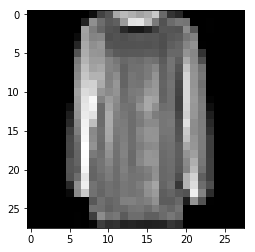

In [7]:
#Just visualising the data
images, labels = iter(trainloader).next()

print(labels[0])

plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r');

We could see that the `labels[0]` correspond to tensor(2) and the image shown is also sweat shirt.

### Defining the model
This is one way of defining the model using `nn.Sequential`. There is also another way of defining the model by sub classing the `nn.Module`

In [12]:
input_size = 784
hidden_size = [256, 128, 64]
output_size = 10


model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(input_size, hidden_size[0])),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(hidden_size[0], hidden_size[1])),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(hidden_size[1], hidden_size[2])),
    ('relu3', nn.ReLU()),
    ('fc4', nn.Linear(hidden_size[2], output_size)),
    ('log_soft1', nn.LogSoftmax(dim=1))
]))

model

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (log_soft1): LogSoftmax()
)

In [14]:
#we will use Negative Logarithmic Loss as our loss function and Adam optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
epochs = 15
running_loss = 0
steps = 0
print_every = 50

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        steps += 1
        
        #reshaping the 28x28 image to 784 to pass into the model.
        images = images.view(images.shape[0], -1)
        
        #clearning the gradients
        optimizer.zero_grad()
        #passing the images through the model
        logits = model(images)
        #calculating the loss
        loss = criterion(logits, labels)
        #passing the loss backward
        loss.backward()
        #updating the weights
        optimizer.step()
        
        running_loss += loss.item()
        
      
    else:
        #here we will validate the model that is trained till now.
        with torch.no_grad():
            accuracy = 0
            test_loss = 0
            
            for images, labels in testloader:
                
                images = images.view(images.shape[0], -1)
                
                logits = model(images)
                test_loss += criterion(logits, labels)
                
                output = torch.exp(logits)
                
                top_p, top_class = output.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
                
            print('Epochs {}/{}:'.format(e+1, epochs),
                 'Training loss: {:.3f}'.format(running_loss/len(trainloader)), 
                 'Testing loss: {:.3f}'.format(test_loss/len(testloader)),
                 'Test Accuracy: {:.3f}'.format(accuracy/len(testloader)))
                

Epochs 1/15: Training loss: 0.519 Testing loss: 0.422 Test Accuracy: 0.845
Epochs 2/15: Training loss: 0.372 Testing loss: 0.372 Test Accuracy: 0.865
Epochs 3/15: Training loss: 0.334 Testing loss: 0.395 Test Accuracy: 0.857
Epochs 4/15: Training loss: 0.314 Testing loss: 0.351 Test Accuracy: 0.873
Epochs 5/15: Training loss: 0.294 Testing loss: 0.346 Test Accuracy: 0.873
Epochs 6/15: Training loss: 0.278 Testing loss: 0.353 Test Accuracy: 0.871
Epochs 7/15: Training loss: 0.264 Testing loss: 0.347 Test Accuracy: 0.877
Epochs 8/15: Training loss: 0.251 Testing loss: 0.334 Test Accuracy: 0.883
Epochs 9/15: Training loss: 0.239 Testing loss: 0.354 Test Accuracy: 0.877
Epochs 10/15: Training loss: 0.230 Testing loss: 0.338 Test Accuracy: 0.886
Epochs 11/15: Training loss: 0.218 Testing loss: 0.355 Test Accuracy: 0.880
Epochs 12/15: Training loss: 0.210 Testing loss: 0.375 Test Accuracy: 0.879
Epochs 13/15: Training loss: 0.202 Testing loss: 0.339 Test Accuracy: 0.883
Epochs 14/15: Trainin

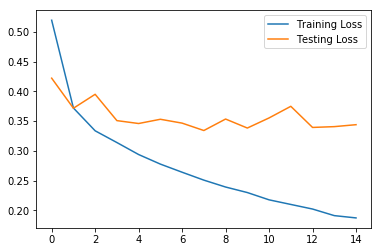

In [16]:
#plotting the training and testing loss that we have stored.
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend();

Here in the graph we see that, our training loss decreses with number of epochs, but our testing loss decreases in the first few epochs and next it starts increasing. This is because the model overfits on the data. To get rid of overfitting we use the `Dropout`. The notebook using `Dropout` can be found with name `Fashion MNIST Dropout`

T-shirt/top


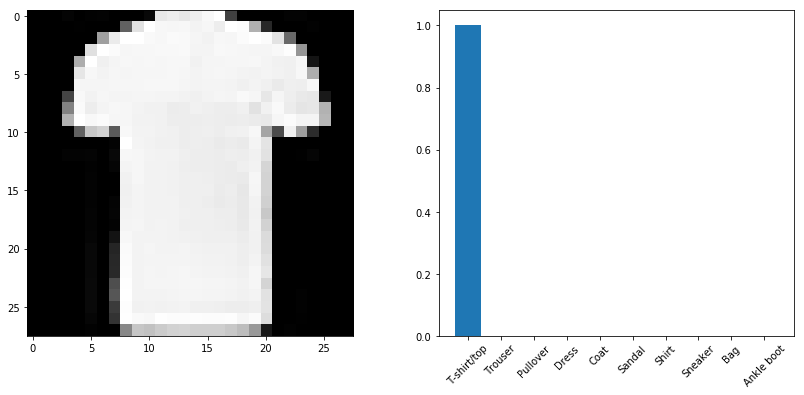

In [28]:
#Here we plot the image and the prediction from the output. 

#gets the images and labels
images, labels = next(iter(testloader))
img = images[0].view(1,-1)

#passes the images from the model
logits = torch.exp(model(img))



plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')

y = logits.detach().numpy()
N = y.shape[1]
x = np.arange(N)

plt.subplot(1,2,2)
plt.bar(x,y.squeeze())
xl = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.xticks(x,xl, rotation=45);

print(xl[labels[0].item()])